# Relax data science Challenge

#### Loading Libraries

In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


#### Data loading

In [281]:
user = pd.read_csv("takehome_users.csv",encoding="latin-1")
user_adopted = pd.read_csv("takehome_user_engagement.csv",encoding="latin-1")

#### Visual inspection

In [282]:
print(user.head(5))
print(user_adopted.head(5))

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [283]:
print(user.info())
print(user_adopted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Co

#### converting object data type to date time

In [284]:
user["creation_time"] = pd.to_datetime(user["creation_time"])
user_adopted["time_stamp"] = pd.to_datetime(user_adopted["time_stamp"])

In [285]:
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### As last_session_creation_time is closly realted to creation_time by floor division of 10^9 hence replacing the missing values in last_session_creation_time by practically converting creation_time into it and replacing ot all.

In [288]:
user.dropna(subset=["last_session_creation_time"],inplace=True)
user.creation_time = user.creation_time.values.astype(float) // 10**9
user.last_session_creation_time.fillna(user.creation_time, inplace=True)
user.invited_by_user_id.fillna(0,inplace=True)

#### Grouping user_adopted by user_id and using grouping by time_stamp, to get the number of visiters.

In [294]:
user_adopted_grouped = user_adopted.set_index("time_stamp")
user_adopted_grouped = user_adopted_grouped.groupby(['user_id',pd.Grouper(freq="W")])["visited"].sum().reset_index()
user_adopted_grouped.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-12-01,1
3,2,2013-12-15,1
4,2,2013-12-29,1


#### Filtering for greater than equal to 3 visited counts

In [295]:
adopted_user_df = user_adopted_grouped[user_adopted_grouped["visited"]>=3]
adopted_user_df = adopted_user_df.drop_duplicates(subset="user_id",keep="first")
adopted_user_df.head()

,user_id,time_stamp,visited
7,2,2014-02-09,3
23,10,2013-03-03,3
96,20,2014-03-16,3
110,33,2014-03-23,3
126,42,2012-12-30,4


#### Creating a boolean feature for adopted user. 

In [296]:
adopted_user = adopted_user_df.user_id.values
user["adopted"] = user.object_id.apply(lambda x: True if x in adopted_user else False)

In [297]:
def bar_perc(ax):
    """
    This func adds annotation in top of bar charts.
    this does not work on anything that is not bar or bar 
     chart related plot.
    
    :param ax: class 'matplotlib.axes._subplots.AxesSubplot
    :return: Nonetype
    """
    totals = []  # create a empty list

    for i in ax.patches:  # ax.patches to select each bar as a rectangle
        totals.append(i.get_height())  # .get_height() is used for vertical bar chart use .get_width() for horizontal()

    total = sum(totals)  # for getting total no of elements with height as proxy

    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 100,
                str(round((i.get_height() / total) * 100, 2)) + '%', color='black') 
        # .get_x() gets the starting x-axis and for y-axis use .get_height

#### % of user that are adopted

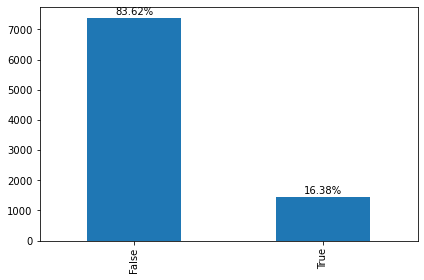

In [298]:
ax =user.adopted.value_counts().plot(kind="bar")
bar_perc(ax)
plt.tight_layout()


16.38 % of the user are adopted

#### Exploratory data analysis

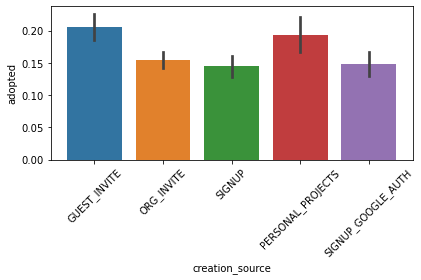

In [303]:
ax=sns.barplot(x='creation_source', y='adopted', data=user)
plt.xticks(rotation=45)
plt.margins(0.05)

plt.tight_layout()

### Machine learning model

In [304]:
df = pd.get_dummies(data=user,columns =["creation_source","org_id"],drop_first=True)

In [305]:
X = df.drop(["adopted","creation_time","name","email","invited_by_user_id","object_id"], axis = 1)
y = df["adopted"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)

#### Gradiant Boosting

In [306]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score


gradient = GradientBoostingRegressor()

In [307]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.40562301 0.51592628 0.45761309 0.47667787 0.47682761]
Average cross-validation score: 0.4665


### Grid Search

In [308]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.36186277964205826

In [309]:
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.23819834 0.41913605 0.33414057 0.3649401  0.32022033]
Average cross-validation score: 0.3353


#### Random Forest Classifier

In [310]:
from sklearn.ensemble import RandomForestClassifier

# Cross validation
clf = RandomForestClassifier()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.87783172 0.90283401 0.89635628 0.89149798 0.88259109]
Average 5-Fold CV Score: 0.8902222134874153


In [311]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

       False       0.92      0.95      0.93      2200
        True       0.70      0.60      0.64       447

    accuracy                           0.89      2647
   macro avg       0.81      0.77      0.79      2647
weighted avg       0.88      0.89      0.88      2647

Test set accuracy: 88.86%


In [312]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=range(0,2), columns=range(0,2))

,0,1
0,2085,115
1,180,267


Text(0.5, 1.0, 'ROC Curve')

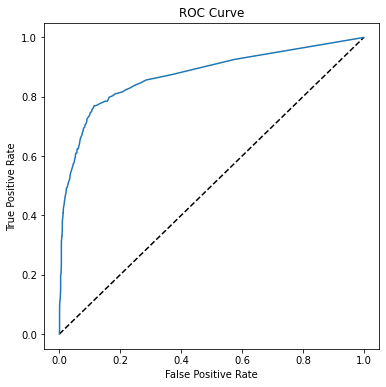

In [313]:
# Compute predicted probabilities
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [314]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8731


In [315]:
fi = pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)), columns = ['features', 'Importance'])
fi.sort_values(by='Importance', ascending=False)

,features,Importance
0,last_session_creation_time,6.016172e-01
3,creation_source_ORG_INVITE,2.253702e-02
1,opted_in_to_mailing_list,1.820262e-02
2,enabled_for_marketing_drip,1.598209e-02
5,creation_source_SIGNUP,1.349683e-02
...,...,...
402,org_id_396,9.662811e-07
261,org_id_255,5.414898e-07
422,org_id_416,2.378081e-07
157,org_id_151,9.992041e-08
